# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [1]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert
from PyEMD import EMD

# regridding package
import xesmf as xe

# ACCESS-NRI intake catalogue
import intake

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


/g/data/es60/pjb581/miniforge3/envs/pyEMD_env/lib/python3.10/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.1
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

## LOAD DATA

In [2]:
%%time

catalog = intake.cat.access_nri

# access to fs38 NCI project where the ACCESS-ESM-1.5 runs are stored
cmip6_fs38_datastore = catalog.search(name='cmip6_fs38').to_source()

# reduce to only ocean variables
cmip6_fs38_ocean_datastore = cmip6_fs38_datastore.search(realm=['ocean','ocnBgchem'], frequency=["mon"], source_id=["ACCESS-ESM1-5"], experiment_id=["historical"], version=["v.*"])


CPU times: user 12.3 s, sys: 1.11 s, total: 13.4 s
Wall time: 16.7 s


In [3]:
%%time

cat_df = cmip6_fs38_ocean_datastore.df
cat_df.head()


CPU times: user 168 μs, sys: 75 μs, total: 243 μs
Wall time: 251 μs


,path,file_type,realm,frequency,table_id,project_id,institution_id,source_id,experiment_id,member_id,variable_id,grid_label,version,time_range
0,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r29i1p1f1/Omon/talk/gn/v20200922/talk_Omon_ACCESS-ESM1-5_historical_r29i1p1f1_gn_195001-195912.nc,l,ocnBgchem,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r29i1p1f1,talk,gn,v20200922,195001-195912
1,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r29i1p1f1/Omon/volcello/gn/v20200922/volcello_Omon_ACCESS-ESM1-5_historical_r29i1p1f1_gn_195001-195912.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r29i1p1f1,volcello,gn,v20200922,195001-195912
2,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r29i1p1f1/Omon/po4/gn/v20200922/po4_Omon_ACCESS-ESM1-5_historical_r29i1p1f1_gn_196001-196912.nc,l,ocnBgchem,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r29i1p1f1,po4,gn,v20200922,196001-196912
3,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r30i1p1f1/Omon/vmo/gn/v20200922/vmo_Omon_ACCESS-ESM1-5_historical_r30i1p1f1_gn_193001-193912.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r30i1p1f1,vmo,gn,v20200922,193001-193912
4,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r30i1p1f1/Omon/arag/gn/v20200922/arag_Omon_ACCESS-ESM1-5_historical_r30i1p1f1_gn_191001-191912.nc,l,ocnBgchem,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r30i1p1f1,arag,gn,v20200922,191001-191912


### Filter for the variables we want

In [4]:
%%time

sst_df = cat_df[(cat_df['variable_id'] == "tos")]
sst_df


CPU times: user 1.61 ms, sys: 426 μs, total: 2.04 ms
Wall time: 1.97 ms


,path,file_type,realm,frequency,table_id,project_id,institution_id,source_id,experiment_id,member_id,variable_id,grid_label,version,time_range
160,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r39i1p1f1/Omon/tos/gn/v20210525/tos_Omon_ACCESS-ESM1-5_historical_r39i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r39i1p1f1,tos,gn,v20210525,185001-201412
505,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r15i1p1f1/Omon/tos/gn/v20200803/tos_Omon_ACCESS-ESM1-5_historical_r15i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r15i1p1f1,tos,gn,v20200803,185001-201412
667,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r13i1p1f1/Omon/tos/gn/v20200803/tos_Omon_ACCESS-ESM1-5_historical_r13i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r13i1p1f1,tos,gn,v20200803,185001-201412
670,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r27i1p1f1/Omon/tos/gn/v20200922/tos_Omon_ACCESS-ESM1-5_historical_r27i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r27i1p1f1,tos,gn,v20200922,185001-201412
1083,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r11i1p1f1/Omon/tos/gn/v20200803/tos_Omon_ACCESS-ESM1-5_historical_r11i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r11i1p1f1,tos,gn,v20200803,185001-201412
1202,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r40i1p1f1/Omon/tos/gn/v20210525/tos_Omon_ACCESS-ESM1-5_historical_r40i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r40i1p1f1,tos,gn,v20210525,185001-201412
1378,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r8i1p1f1/Omon/tos/gn/v20200529/tos_Omon_ACCESS-ESM1-5_historical_r8i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r8i1p1f1,tos,gn,v20200529,185001-201412
1750,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r12i1p1f1/Omon/tos/gn/v20200803/tos_Omon_ACCESS-ESM1-5_historical_r12i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r12i1p1f1,tos,gn,v20200803,185001-201412
1812,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r34i1p1f1/Omon/tos/gn/v20210525/tos_Omon_ACCESS-ESM1-5_historical_r34i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r34i1p1f1,tos,gn,v20210525,185001-201412
1865,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r33i1p1f1/Omon/tos/gn/v20210525/tos_Omon_ACCESS-ESM1-5_historical_r33i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r33i1p1f1,tos,gn,v20210525,185001-201412


### get the paths to the data

In [5]:
sst_paths = sst_df['path']
sst_members = sst_df['member_id']


### Load the data

In [6]:
%%time

sst_ensemble = {}
for i,path in enumerate(sst_paths):
    print(i, path)
    sst_ensemble[sst_members.iloc[i]] = xr.open_dataset(str(path))['tos']

sst_ensemble = xr.Dataset(sst_ensemble)
sst_ensemble


0 /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r39i1p1f1/Omon/tos/gn/v20210525/tos_Omon_ACCESS-ESM1-5_historical_r39i1p1f1_gn_185001-201412.nc
1 /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r15i1p1f1/Omon/tos/gn/v20200803/tos_Omon_ACCESS-ESM1-5_historical_r15i1p1f1_gn_185001-201412.nc
2 /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r13i1p1f1/Omon/tos/gn/v20200803/tos_Omon_ACCESS-ESM1-5_historical_r13i1p1f1_gn_185001-201412.nc
3 /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r27i1p1f1/Omon/tos/gn/v20200922/tos_Omon_ACCESS-ESM1-5_historical_r27i1p1f1_gn_185001-201412.nc
4 /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r11i1p1f1/Omon/tos/gn/v20200803/tos_Omon_ACCESS-ESM1-5_historical_r11i1p1f1_gn_185001-201412.nc
5 /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r40i1p1f1/Omon/tos/gn/v20210525/tos_Omon_ACCESS-ESM1-5_historical_r40i1p1f1_gn_185001-201412.nc
6 /g

<xarray.Dataset> Size: 34GB
Dimensions:    (time: 1980, j: 300, i: 360)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
Data variables: (12/40)
    r39i1p1f1  (time, j, i) float32 855MB ...
    r15i1p1f1  (time, j, i) float32 855MB ...
    r13i1p1f1  (time, j, i) float32 855MB ...
    r27i1p1f1  (time, j, i) float32 855MB ...
    r11i1p1f1  (time, j, i) float32 855MB ...
    r40i1p1f1  (time, j, i) float32 855MB ...
    ...         ...
    r30i1p1f1  (time, j, i) float32 855MB ...
    r38i1p1f1  (time, j, i) float32 855MB ...
    r18i1p1f1  (time, j, i) float32 855MB ...
    r20i1p1f1  (time, j, i) float32 855MB ...
    r25i1p1f1  (time, j, i) float32 855MB ...
    r24i1p1f1  (time, j, i) float32 855MB ...

## LOAD DATA (ARD)

In [2]:
dat = xr.open_dataset("/scratch/es60/ard/models/ACCESS-ESM15/ARD/ACCESS-ESM15-historical-Omon-o2-chunk4time.zarr", engine="zarr").sel(lev=200, method='nearest')['o2']
dat

<xarray.DataArray 'o2' (member: 40, time: 1980, j: 300, i: 360)> Size: 34GB
[8553600000 values with dtype=float32]
Coordinates:
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
    latitude   (j, i) float64 864kB ...
    lev        float64 8B 205.0
    longitude  (j, i) float64 864kB ...
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
Dimensions without coordinates: member
Attributes:
    cell_measures:   area: areacello volume: volcello
    cell_methods:    area: mean where sea time: mean
    comment:         'Mole concentration' means number of moles per unit volu...
    long_name:       Dissolved Oxygen Concentration
    original_units:  mmol m-3
    standard_name:   mole_concentration_of_dissolved_molecular_oxygen_in_sea_...
    units:           mol m-3

## quick look

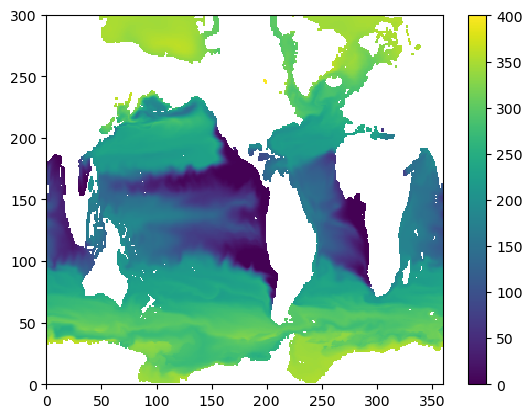

In [4]:
plt.figure()
plt.pcolormesh(dat.isel(member=0, time=0)*1e3)
plt.colorbar()


## take climatology and anomaly

In [5]:
%%time

# Step 1: Calculate the climatology (mean for each month over all years)
oxy_climatology = dat.groupby("time.month").mean("time")*1e3

# Step 2: Compute the anomaly by subtracting the climatology from the original data
oxy_anomalies = dat.groupby("time.month")*1e3 - sst_climatology
oxy_anomalies


TypeError: GroupBy objects only support binary ops when the other argument is a Dataset or DataArray

34.2144 GB


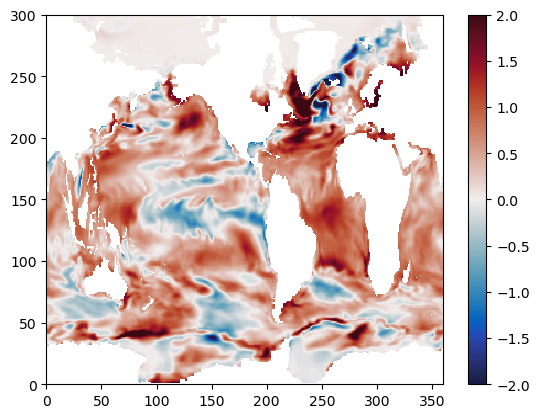

In [6]:
plt.figure()
plt.pcolormesh(oxy_anomalies.isel(member=0, time=-1), cmap=cmo.balance, vmin=-20, vmax=20)
plt.colorbar()

print(oxy_anomalies.nbytes / 1e9, "GB")  # Convert bytes to MB

## detrend the data

In [7]:
%%time

### remove global trend
def detrend_1d(arr):
    """Remove the linear trend from a 1D array."""
    x = np.arange(len(arr))
    # Fit a linear trend
    coeffs = np.polyfit(x, arr, 1)
    trend = np.polyval(coeffs, x)
    # Remove the trend
    detrended = arr - trend
    return detrended

# Apply the function to each variable in the anomalies dataset
sst_detrended_anomalies = {}

for mem in sst_anomalies.coords['member'].values:
    var = "r%ii1p1f1"%(mem)
    print(f"Processing: {var}")  # Print the current variable name
    
    sst_detrended_anomalies[var] = xr.apply_ufunc(
        detrend_1d,
        sst_anomalies.isel(member=mem),  # Apply to each variable
        input_core_dims=[["time"]],
        output_core_dims=[["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[sst_anomalies.isel(member=mem).dtype]
    )

# Convert dictionary back to an xarray Dataset
sst_detrended_anomalies = xr.Dataset(sst_detrended_anomalies)

# Check the detrended dataset
print(sst_detrended_anomalies)


Processing: r0i1p1f1
Processing: r1i1p1f1
Processing: r2i1p1f1
Processing: r3i1p1f1
Processing: r4i1p1f1
Processing: r5i1p1f1
Processing: r6i1p1f1
Processing: r7i1p1f1
Processing: r8i1p1f1
Processing: r9i1p1f1
Processing: r10i1p1f1
Processing: r11i1p1f1
Processing: r12i1p1f1
Processing: r13i1p1f1
Processing: r14i1p1f1
Processing: r15i1p1f1
Processing: r16i1p1f1
Processing: r17i1p1f1
Processing: r18i1p1f1
Processing: r19i1p1f1
Processing: r20i1p1f1
Processing: r21i1p1f1
Processing: r22i1p1f1
Processing: r23i1p1f1
Processing: r24i1p1f1
Processing: r25i1p1f1
Processing: r26i1p1f1
Processing: r27i1p1f1
Processing: r28i1p1f1
Processing: r29i1p1f1
Processing: r30i1p1f1
Processing: r31i1p1f1
Processing: r32i1p1f1
Processing: r33i1p1f1
Processing: r34i1p1f1
Processing: r35i1p1f1
Processing: r36i1p1f1
Processing: r37i1p1f1
Processing: r38i1p1f1
Processing: r39i1p1f1
<xarray.Dataset> Size: 34GB
Dimensions:    (i: 360, j: 300, time: 1980)
Coordinates:
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 

34.21617816 GB


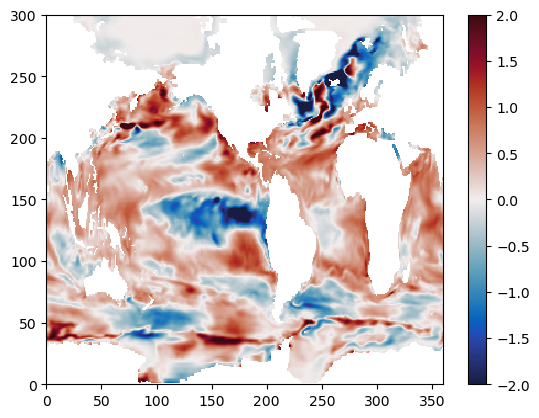

In [8]:
plt.figure()
plt.pcolormesh(sst_detrended_anomalies['r1i1p1f1'].isel(time=-1), cmap=cmo.balance, vmin=-2, vmax=2)
plt.colorbar()

print(sst_detrended_anomalies.nbytes / 1e9, "GB")  # Convert bytes to MB

## retrieve the linear least squares trend

In [9]:
%%time

# Create a dictionary to store trends for each variable
sst_trends = {}

# Get the time coordinate
dates = sst_anomalies.coords["time"]
time_length = len(dates)

for mem in sst_anomalies.coords['member'].values:
    var = "r%ii1p1f1"%(mem)
    print(f"Processing: {var}")  # Print the current variable name
   
    # Compute the trend for the current variable
    var_trend = sst_anomalies.isel(member=mem) - sst_detrended_anomalies[var]  # Trend component
    var_trend = (var_trend.sel(time=dates[-1]) - var_trend.sel(time=dates[0])) / time_length * 12 * 10  # Scale per decade

    # Store the trend in the dictionary
    sst_trends[var] = var_trend

# Convert the dictionary into an xarray Dataset
sst_trends = xr.Dataset(sst_trends)

# Print the final trends dataset
print(sst_trends)


Processing: r0i1p1f1
Processing: r1i1p1f1
Processing: r2i1p1f1
Processing: r3i1p1f1
Processing: r4i1p1f1
Processing: r5i1p1f1
Processing: r6i1p1f1
Processing: r7i1p1f1
Processing: r8i1p1f1
Processing: r9i1p1f1
Processing: r10i1p1f1
Processing: r11i1p1f1
Processing: r12i1p1f1
Processing: r13i1p1f1
Processing: r14i1p1f1
Processing: r15i1p1f1
Processing: r16i1p1f1
Processing: r17i1p1f1
Processing: r18i1p1f1
Processing: r19i1p1f1
Processing: r20i1p1f1
Processing: r21i1p1f1
Processing: r22i1p1f1
Processing: r23i1p1f1
Processing: r24i1p1f1
Processing: r25i1p1f1
Processing: r26i1p1f1
Processing: r27i1p1f1
Processing: r28i1p1f1
Processing: r29i1p1f1
Processing: r30i1p1f1
Processing: r31i1p1f1
Processing: r32i1p1f1
Processing: r33i1p1f1
Processing: r34i1p1f1
Processing: r35i1p1f1
Processing: r36i1p1f1
Processing: r37i1p1f1
Processing: r38i1p1f1
Processing: r39i1p1f1
<xarray.Dataset> Size: 19MB
Dimensions:    (i: 360, j: 300)
Coordinates:
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 

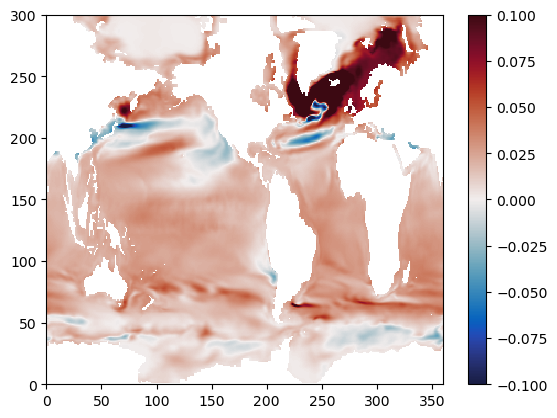

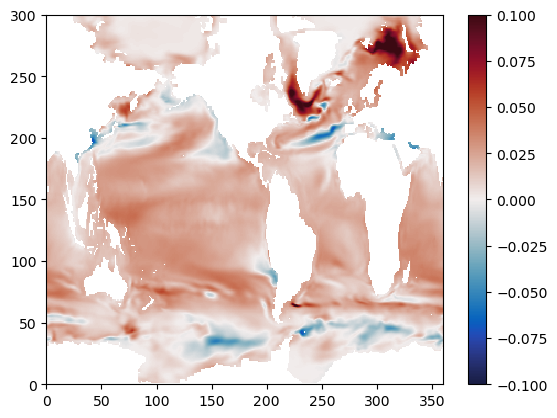

In [10]:
plt.figure()
plt.pcolormesh(sst_trends['r1i1p1f1'], cmap=cmo.balance, vmin=-0.1, vmax=0.1)
plt.colorbar()

plt.figure()
plt.pcolormesh(sst_trends['r2i1p1f1'], cmap=cmo.balance, vmin=-0.1, vmax=0.1)
plt.colorbar()


## Undertake the decomposition at each grid cell across the ocean

In [18]:
%%time

from scipy.signal import hilbert

years = np.arange(1850+0.5/12, 2014+11.51/12, 1/12)
times = sst_anomalies.coords['time'].values
lats = sst_anomalies.coords['j'].values
lons = sst_anomalies.coords['i'].values
# Get the latitudes and longitudes (2D arrays)
lons_2d = sst_detrended_anomalies.coords["longitude"].values  # (j, i)
lats_2d = sst_detrended_anomalies.coords["latitude"].values  # (j, i)

def find_imf_freq(imfs):
    inst_freqs = []
    for imf in imfs:
        analytic_signal = hilbert(imf)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(years))
        inst_freqs.append(instantaneous_frequency)
    return np.array([np.mean(freq) for freq in inst_freqs])
    

def set_imfs(imfs, freqs):
    # add IMFs to the master array and merge IMFs into sub-annual, inter-annual, decadal and trend
    lentmp = np.shape(imfs)[0]
    if lentmp > 0:
        mask1 = freqs > 1                       # oscillates with period less than 1 year
        mask2 = (freqs < 1) & (freqs > 0.2)     # oscillates with period between 1 and 5 years
        mask3 = (freqs < 0.2) & (freqs > 0.0)   # oscillates with period greater than 5 years
        out1 = np.mean(imfs[mask1],axis=0)
        out2 = np.mean(imfs[mask2],axis=0)
        out3 = np.mean(imfs[mask3],axis=0)
    else:
        out1 = np.zeros(len(imfs[0,:]))
        out2 = np.zeros(len(imfs[0,:]))
        out3 = np.zeros(len(imfs[0,:]))
    return np.array([out1, out2, out3])


### **Function for Processing Each Grid Point**
def process_grid_point(iy, ix, var):
    emd = EMD()
    time_series = sst_detrended_anomalies[var].isel(i=ix, j=iy).values
    
    if np.any(np.isnan(time_series)):
        return np.zeros((3, len(times)))  # Return zero IMFs for NaN points

    # Compute EMD decomposition
    sstimfs = emd(time_series, max_imf=5)

    # Compute IMF frequencies and classify IMFs
    sst_freqs = find_imf_freq(sstimfs)
    return set_imfs(sstimfs, sst_freqs)


CPU times: user 899 μs, sys: 432 μs, total: 1.33 ms
Wall time: 1.21 ms


In [20]:
%%time

import multiprocessing

# Create a dictionary to store results for each variable
imf_results = {}

# Iterate over each variable in the dataset
for mem,var in enumerate(list(sst_detrended_anomalies.data_vars.keys())[:]):
#var = "r38i1p1f1"
#mem = 37
#if var == "r38i1p1f1":
    print(f"Processing variable: {var}")
    sst_imfs = np.zeros((3,len(times),len(lats),len(lons)))

    # Apply multiprocessing to speed up processing across grid points
    with multiprocessing.Pool(processes=16) as pool:  # Adjust based on available CPU cores
        results = pool.starmap(
            process_grid_point, [ 
                (iy, ix, var) 
                for iy in range(len(lats)) 
                for ix in range(len(lons)) 
            ]
        )
    
    sst_imfs = (np.asarray(results)
              .reshape(len(lats), len(lons), 3, len(times))
              .transpose(2, 3, 0, 1))         # -> (IMF,time,lat,lon)
    

    #for ix, lon in enumerate(lons):
    #    if ix % 40 == 0:
    #        print(f"Processing longitude index: {ix}/{len(lons)} for {var}")
    #    for iy, lat in enumerate(lats):
    #        # Extract time series at this grid point
    #        time_series = sst_detrended_anomalies[var].isel(i=ix, j=iy).values
    #        # Skip if NaN values are present
    #        if np.any(np.isnan(time_series)):
    #            continue
    #        # Decompose using EMD (Empirical Mode Decomposition)
    #        sstimfs = emd(time_series, max_imf=5)  # Decomposing into max 5 IMFs
    #        # Determine the frequencies of the IMFs
    #        sst_freqs = find_imf_freq(sstimfs)
    #        # Store the IMFs, merging into categories (sub-annual, inter-annual, etc.)
    #        sst_imfs[:, :, iy, ix] = set_imfs(sstimfs, sst_freqs)

    ### Create Dataset
    name1=f"{var}_sst_imfs"
    name2=f"{var}_sst_anom"
    name3=f"{var}_sst_detr"
    name4=f"{var}_sst_trend"
    # Convert the NumPy array to an xarray DataArray
    imf_da = xr.Dataset(
        {
            name1: (["IMF", "time", "j", "i"], sst_imfs),
            name2: (["time", "j", "i"], sst_anomalies.isel(member=mem).values),
            name3: (["time", "j", "i"], sst_detrended_anomalies[var].transpose("time", "j", "i").values),
            name4: (["j", "i"], sst_trends[var].values),
        },
        coords={
            "IMF": np.arange(1,4,1),  # IMF modes
            "time": times,
            "j": lats,
            "i": lons,
            "longitude": (["j", "i"], lons_2d),  # 2D longitude
            "latitude": (["j", "i"], lats_2d)  # 2D latitude
        },
    )

    ### Save
    file_name = f"{var}_sst_imfs.nc"
    save_dir = "/g/data/es60/pjb581/SPC/data/"
    file_path = os.path.join(save_dir, file_name)
    imf_da.to_netcdf(file_path)
    print(f"Saved {file_name}")

    # Store the IMFs for this variable in the dictionary
    imf_results[var] = sst_imfs

print("Finished processing all variables.")



Processing variable: r38i1p1f1


KeyError: 'r38i1p1f1'